In [2]:
# imports
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# statistics stack
from scipy import stats

# machine learning stack
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

# miscellaneous
import warnings
warnings.simplefilter('ignore')

#GRID SEARCH

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin


In [3]:
import pandas as pd

df = pd.read_csv('data/train.csv')

df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# getting rid of the three location <=13, groupby locations and ordering date, separate the train test split data:

# Convert 'Date' to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])

# Create empty lists to store train and test DataFrames
train_dfs = []
test_dfs = []

# Creating subsets of locations
location_groups = df.groupby('Place_ID')

# Filter out groups that have fewer than 13 unique dates
filtered_groups = {
    location: sub_df for location, sub_df in location_groups 
    if sub_df['Date'].nunique() >= 13
}

# Debug: Print number of filtered groups
print(f"Number of filtered groups (locations with >=13 unique dates): {len(filtered_groups)}")

# Iterate through each filtered group
for location, sub_df in filtered_groups.items():
    # Sort each subset DataFrame by the 'Date' column in ascending order
    sub_df = sub_df.sort_values(by='Date', ascending=True)
    # Debug: Check the number of rows in the sorted sub_df
    print(f"Location: {location}, Number of rows: {len(sub_df)}")
    # Select the last three rows for the test set
    test_df = sub_df.tail(3)
    # Select the remaining rows for the train set
    train_df = sub_df.iloc[:-3]
    # Debug: Verify the number of rows in train and test sets for this location
    print(f"Location: {location}, Train Rows: {len(train_df)}, Test Rows: {len(test_df)}")
    # Append the split dataframes to their respective lists
    train_dfs.append(train_df)
    test_dfs.append(test_df)

# Concatenate all the train and test DataFrames into separate DataFrames
df_train_split = pd.concat(train_dfs, ignore_index=True)
df_test_split = pd.concat(test_dfs, ignore_index=True)

# Display or use the resulting DataFrames
print("Training set:")
print(df_train_split.head())  # Display the first few rows for verification
print("\nTest set:")
print(df_test_split.head())   # Display the first few rows for verification

# Check the number of rows in the test set for each location to verify correctness
print("\nNumber of rows per Place_ID in the test set:")
print(df_test_split['Place_ID'].value_counts())

Number of filtered groups (locations with >=13 unique dates): 337
Location: 010Q650, Number of rows: 94
Location: 010Q650, Train Rows: 91, Test Rows: 3
Location: 05EC30X, Number of rows: 90
Location: 05EC30X, Train Rows: 87, Test Rows: 3
Location: 0DPWHX8, Number of rows: 94
Location: 0DPWHX8, Train Rows: 91, Test Rows: 3
Location: 0GBXTHY, Number of rows: 94
Location: 0GBXTHY, Train Rows: 91, Test Rows: 3
Location: 0HYPV1N, Number of rows: 94
Location: 0HYPV1N, Train Rows: 91, Test Rows: 3
Location: 0I2XREH, Number of rows: 65
Location: 0I2XREH, Train Rows: 62, Test Rows: 3
Location: 0KV6RJ1, Number of rows: 94
Location: 0KV6RJ1, Train Rows: 91, Test Rows: 3
Location: 0MGEY68, Number of rows: 94
Location: 0MGEY68, Train Rows: 91, Test Rows: 3
Location: 0O9R6AD, Number of rows: 92
Location: 0O9R6AD, Train Rows: 89, Test Rows: 3
Location: 0PP73FZ, Number of rows: 94
Location: 0PP73FZ, Train Rows: 91, Test Rows: 3
Location: 0RYZQUU, Number of rows: 91
Location: 0RYZQUU, Train Rows: 88, T

In [5]:
# Save DataFrame to CSV
df_train_split.to_csv('air-pollution-df-train.csv', index=False)  # index=False means do not write row numbers

# Save DataFrame to CSV
df_test_split.to_csv('air-pollution-df-test.csv', index=False)  # index=False means do not write row numbers


In [6]:
#lag1 column with the target of the day before:
#  Sort the DataFrame by ‘Place_ID’ and ‘Date’ to ensure correct ordering
#df_train_split = df_train_split.sort_values(by=[‘Place_ID’, ‘Date’])
#  Group the data by ‘Place_ID’ and apply the time series shift
#df_train_split[‘lag1’] = df_train_split.groupby(‘Place_ID’)[‘target’].shift(1)
#  Drop rows where ‘log1’ is NaN (the first row in each group)
#df_train_split = df_train_split.dropna(subset=[‘lag1’])
#  Reset the index if needed (optional)
#df_train_split = df_train_split.reset_index(drop=True)
# Display the final DataFrame
#df_train_split.head(5)


#first baseline model with X as lag 1 and Y as target:

#  Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
#  Make predictions on the test set
y_pred = model.predict(X_test)
#  Evaluate the model (Mean Squared Error and R-squared)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



NameError: name 'X_train' is not defined

## identify the columns we want to continue working with 

In [7]:
# Check percentage of missing values in each column
missing_values = df_train_split.isnull().mean().sort_values(ascending=False)

# Display columns with more than, say, 30% missing values 
high_null_columns = missing_values[missing_values > 0.30]
print(f"Columns with > 30% missing values:\n{high_null_columns}")

# Drop or consider imputing these columns in further analysis if necessary



Columns with > 30% missing values:
L3_CH4_solar_zenith_angle                        0.818385
L3_CH4_solar_azimuth_angle                       0.818385
L3_CH4_sensor_zenith_angle                       0.818385
L3_CH4_sensor_azimuth_angle                      0.818385
L3_CH4_aerosol_optical_depth                     0.818385
L3_CH4_aerosol_height                            0.818385
L3_CH4_CH4_column_volume_mixing_ratio_dry_air    0.818385
dtype: float64


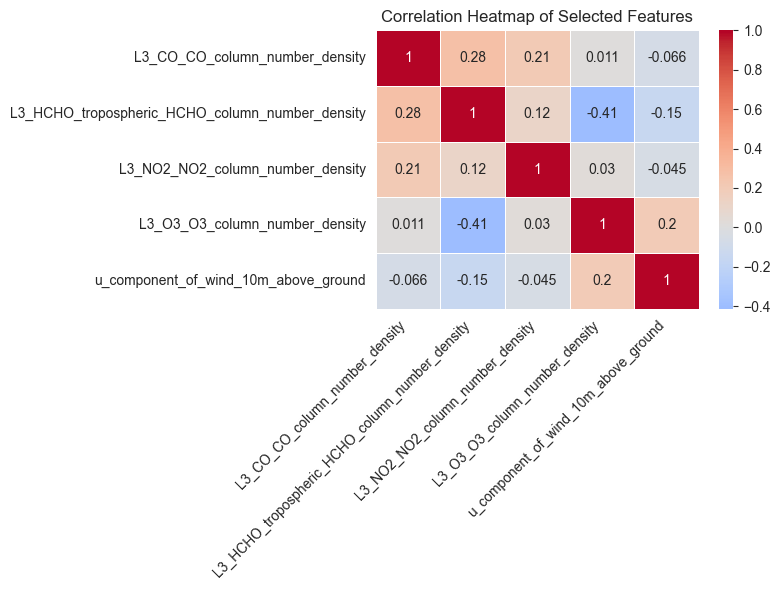

In [8]:
#CHECK FOR MULTICOLINEARITY

import matplotlib.pyplot as plt
import seaborn as sns

# Select the specified features for the heatmap
selected_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground"
]

# Create a DataFrame with the selected features
df_selected = df_train_split[selected_features]

# Calculate the correlation matrix for the selected features
correlation_matrix = df_selected.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

# Set title and labels
plt.title('Correlation Heatmap of Selected Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

## new features 

- L3_CO_CO_column_number_density: 0.400696
- L3_HCHO_tropospheric_HCHO_column_number_density: 0.349392
- L3_NO2_NO2_column_number_density: 0.301790
- L3_O3_O3_column_number_density: 0.147483
- u_component_of_wind_10m_above_ground: 0.147423

Correlation Matrix:
                                                 L3_CO_CO_column_number_density   
L3_CO_CO_column_number_density                                         1.000000  \
L3_HCHO_tropospheric_HCHO_column_number_density                        0.277512   
L3_NO2_NO2_column_number_density                                       0.206372   
L3_O3_O3_column_number_density                                         0.011328   
u_component_of_wind_10m_above_ground                                  -0.066239   

                                                 L3_HCHO_tropospheric_HCHO_column_number_density   
L3_CO_CO_column_number_density                                                          0.277512  \
L3_HCHO_tropospheric_HCHO_column_number_density                                         1.000000   
L3_NO2_NO2_column_number_density                                                        0.115344   
L3_O3_O3_column_number_density                                                   

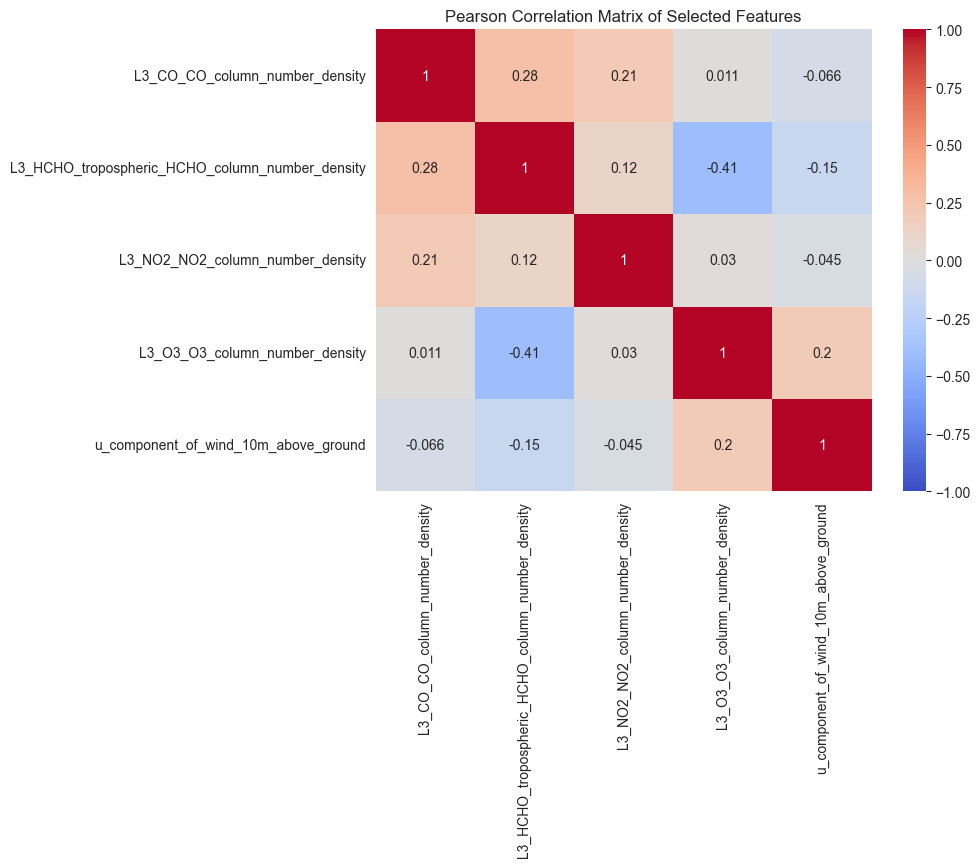

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the 5 features for testing independence
features_to_test = df_train_split[['L3_CO_CO_column_number_density', 
                                   'L3_HCHO_tropospheric_HCHO_column_number_density',
                                   'L3_NO2_NO2_column_number_density', 
                                   'L3_O3_O3_column_number_density', 
                                   'u_component_of_wind_10m_above_ground']]

# Step 1: Calculate the Pearson correlation matrix
correlation_matrix = features_to_test.corr(method='pearson')

# Step 2: Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Step 3: Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix of Selected Features')
plt.show()

In [11]:
#set num and cat
num_features = df_train_split[['L3_CO_CO_column_number_density', 
                                   'L3_HCHO_tropospheric_HCHO_column_number_density',
                                   'L3_NO2_NO2_column_number_density', 
                                   'L3_O3_O3_column_number_density', 
                                   'u_component_of_wind_10m_above_ground']]
                                   
                                   
cat_features = df_train_split[["Place_ID"]]

## Baseline Model

In [22]:
#BASELINE MODEL w/ mape
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
                                      

# Custom transformer for mean imputation per Place_ID
class MeanImputerPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col
    def fit(self, X, y=None):
        return self  # No fitting necessary for imputation logic
    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame
        for feature in self.numerical_features:
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.fillna(x.mean()))
        return X
# Define the feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground"
]
categorical_features = ["Place_ID"]
# Define the preprocessing for numerical features: Standardization
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# Define the preprocessing for categorical features: One-hot encode Place_ID
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Define the full pipeline with the custom imputer, preprocessing, and regression model
model = Pipeline(steps=[
    ('mean_imputer', MeanImputerPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Define the target variable
y_train = df_train_split["target"]
X_train = df_train_split[numerical_features + categorical_features]

y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]
# Fit the model on the training data
model.fit(X_train, y_train)
# Make predictions on the test data
y_pred = model.predict(X_test)
# Evaluate the model using Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.6113592062102571


In [23]:
#BASELINE MODEL w/ RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

# Your existing model pipeline setup code...

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 31.61914791572038


In [ ]:
#... on Train and Test Data
from sklearn.metrics import mean_squared_error
import numpy as np

# Your existing model pipeline setup code...

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate RMSE on training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE) on Training Data:", rmse_train)

# Calculate RMSE on test data
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE) on Test Data:", rmse_test)


Root Mean Squared Error (RMSE) on Training Data: 26.853781577803066
Root Mean Squared Error (RMSE) on Test Data: 31.61914791572038


In [ ]:
#BASELINE MODEL RMSE incl df_train_split["log_target"] = np.log(df_train_split["target"])
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# Create log target variable
df_train_split["log_target"] = np.log(df_train_split["target"])

# Custom transformer for mean imputation per Place_ID
class MeanImputerPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col

    def fit(self, X, y=None):
        return self  # No fitting necessary for imputation logic
    
    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame
        for feature in self.numerical_features:
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.fillna(x.mean()))
        return X
    
# Define the feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground"
]
categorical_features = ["Place_ID"]

# Define the preprocessing for numerical features: Standardization
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# Define the preprocessing for categorical features: One-hot encode Place_ID
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Define the full pipeline with the custom imputer, preprocessing, and regression model
model = Pipeline(steps=[
    ('mean_imputer', MeanImputerPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Define the target variable
y_train = df_train_split["log_target"]
X_train = df_train_split[numerical_features + categorical_features]
y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]
# Fit the model on the training data
model.fit(X_train, y_train)
# Make predictions on the test data
y_pred = model.predict(X_test)
# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, np.exp(y_pred), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 39.79705562237595


# MEAN Baseline Model

In [ ]:
placewise_mean = df_train_split.groupby("Place_ID")["target"].mean()
placewise_mean


Place_ID
010Q650     36.472527
05EC30X     39.896552
0DPWHX8     80.241758
0GBXTHY     16.417582
0HYPV1N     89.098901
              ...    
YLLOKEY     27.428571
YLZOBFW     22.560440
YPXSK14    127.252747
YSIXKFZ     28.340659
YWSFY6Q     68.786667
Name: target, Length: 337, dtype: float64

In [ ]:
baseline_model_pred = df_train_split["Place_ID"].apply(lambda x: placewise_mean.loc[x])
baseline_model_pred


0        36.472527
1        36.472527
2        36.472527
3        36.472527
4        36.472527
           ...    
29519    68.786667
29520    68.786667
29521    68.786667
29522    68.786667
29523    68.786667
Name: Place_ID, Length: 29524, dtype: float64

In [ ]:
mean_absolute_percentage_error(df_train_split["target"], baseline_model_pred)


0.4541575160702791

In [ ]:
baseline_model_pred_test = df_test_split["Place_ID"].apply(lambda x: placewise_mean.loc[x])
baseline_model_pred_test


0       36.472527
1       36.472527
2       36.472527
3       39.896552
4       39.896552
          ...    
1006    28.340659
1007    28.340659
1008    68.786667
1009    68.786667
1010    68.786667
Name: Place_ID, Length: 1011, dtype: float64

In [ ]:
mean_absolute_percentage_error(df_test_split["target"], baseline_model_pred_test)

0.44117451120357215

# ------------------------

## Improved model step by step (08.Okt)

In [ ]:
# Custom transformer for interpolation per Place_ID ordered by Date
class InterpolatorPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID", order_by_col="Date"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col
        self.order_by_col = order_by_col
    
    def fit(self, X, y=None):
        return self  # No fitting necessary for interpolation logic

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame
        # Sort by group and date
        X = X.sort_values([self.group_by_col, self.order_by_col])
        for feature in self.numerical_features:
            # Interpolate missing values per group (Place_ID) based on the order of the dates
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.interpolate())
        return X

In [ ]:
# Calculate the 'day_number' feature for the training set, per Place_ID
df_train_split['day_number'] = df_train_split.groupby('Place_ID')['Date'] \
    .transform(lambda x: (pd.to_datetime(x) - pd.to_datetime(x).min()).dt.days)

# Calculate the 'day_number' feature for the test set, per Place_ID
df_test_split['day_number'] = df_test_split.groupby('Place_ID')['Date'] \
    .transform(lambda x: (pd.to_datetime(x) - pd.to_datetime(x).min()).dt.days)

# Add "is_weekend" feature (0 = weekday, 1 = weekend)
df_train_split['is_weekend'] = pd.to_datetime(df_train_split['Date']).dt.dayofweek >= 5
df_test_split['is_weekend'] = pd.to_datetime(df_test_split['Date']).dt.dayofweek >= 5


In [ ]:
# Define the feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground",
    "day_number"
]
categorical_features = ["Place_ID", "is_weekend"]

In [ ]:
# Define the preprocessing for numerical features: Standardization
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [ ]:
# Define the preprocessing for categorical features: One-hot encode Place_ID and is_weekend
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# Define the full pipeline with the custom interpolator, preprocessing, and placeholder model
pipeline = Pipeline(steps=[
    ('interpolator', InterpolatorPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Placeholder; will be replaced in the GridSearch
])

In [ ]:
# Define the target variable
y_train = df_train_split["target"]
X_train = df_train_split[numerical_features + categorical_features]

y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]


In [ ]:
# Define the parameter grid for GridSearch
param_grid = {
    'regressor': [LinearRegression(), Lasso()],
    'regressor__alpha': [0.01, 0.1, 1, 10],  # Only used for Lasso
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1
)

In [ ]:
# Fit the GridSearch on the training data
grid_search.fit(X_train, y_train)

# Make predictions using the best model found
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model using Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Best parameters found:", grid_search.best_params_)
print("Mean Absolute Percentage Error (MAPE):", mape)

ValueError: Invalid parameter 'alpha' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].

In [ ]:
df_train_split['Date'] = pd.to_datetime(df_train_split['Date'])
df_test_split['Date'] = pd.to_datetime(df_test_split['Date'])


In [29]:
#the above all together --- date error


df_train_split['Date'] = pd.to_datetime(df_train_split['Date'])
df_test_split['Date'] = pd.to_datetime(df_test_split['Date'])

# Custom transformer for interpolation per Place_ID ordered by Date
class InterpolatorPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID", order_by_col="Date"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col
        self.order_by_col = order_by_col
    
    def fit(self, X, y=None):
        return self  # No fitting necessary for interpolation logic

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame
        # Sort by group and date
        X = X.sort_values([self.group_by_col, self.order_by_col])
        for feature in self.numerical_features:
            # Interpolate missing values per group (Place_ID) based on the order of the dates
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.interpolate())
        return X

# Generate 'day_number' feature for train and test sets
df_train_split['day_number'] = df_train_split.groupby('Place_ID')['Date'] \
    .transform(lambda x: (pd.to_datetime(x) - pd.to_datetime(x).min()).dt.days)

df_test_split['day_number'] = df_test_split.groupby('Place_ID')['Date'] \
    .transform(lambda x: (pd.to_datetime(x) - pd.to_datetime(x).min()).dt.days)

# Add "is_weekend" feature (0 = weekday, 1 = weekend)
df_train_split['is_weekend'] = pd.to_datetime(df_train_split['Date']).dt.dayofweek >= 5
df_test_split['is_weekend'] = pd.to_datetime(df_test_split['Date']).dt.dayofweek >= 5

# Define the feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground",
    "day_number"
]
categorical_features = ["Place_ID", "is_weekend"]

# Define preprocessing for numerical features: Standardization
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features: One-hot encode Place_ID and is_weekend
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the full pipeline with the custom interpolator, preprocessing, and placeholder model
pipeline = Pipeline(steps=[
    ('interpolator', InterpolatorPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Placeholder; will be replaced in the GridSearch
])

# Define the target variable
y_train = df_train_split["target"]
X_train = df_train_split[numerical_features + categorical_features]

y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]

# Define the parameter grid for GridSearch (for Lasso and Linear Regression)
param_grid = [
    {'regressor': [LinearRegression()]},  # No parameters for Linear Regression
    {'regressor': [Lasso()], 'regressor__alpha': [0.01, 0.1, 1, 10]}  # Alpha for Lasso
]

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1
)

# Fit the GridSearch on the training data
grid_search.fit(X_train, y_train)

# Make predictions using the best model found
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model using Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Best parameters found:", grid_search.best_params_)
print("Mean Absolute Percentage Error (MAPE):", mape)


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/base.py", line 881, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_86428/4253080357.py", line 20, in transform
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/pandas/core/frame.py", line 6750, in sort_values
    keys = [self._get_label_or_level_values(x, axis=axis) for x in by]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/pandas/core/frame.py", line 6750, in <listcomp>
    keys = [self._get_label_or_level_values(x, axis=axis) for x in by]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/pandas/core/generic.py", line 1778, in _get_label_or_level_values
    raise KeyError(key)
KeyError: 'Date'


In [39]:
# fixed date and nan error 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Convert 'Date' to datetime format
df_train_split['Date'] = pd.to_datetime(df_train_split['Date'])
df_test_split['Date'] = pd.to_datetime(df_test_split['Date'])

#modified interpolation to handle missing data
class InterpolatorPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID", order_by_col="Date"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col
        self.order_by_col = order_by_col
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Ensure that the 'Date' column is present before sorting and interpolating
        if self.order_by_col not in X.columns:
            raise KeyError(f"{self.order_by_col} column is missing from the DataFrame.")
        
        # Sort by group and date
        X = X.sort_values([self.group_by_col, self.order_by_col])
        
        for feature in self.numerical_features:
            # Interpolate missing values per group (Place_ID) based on the order of the dates
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.interpolate())
        
        # If any NaNs remain, fill them with a default value (e.g., mean, 0, or another method)
        X[self.numerical_features] = X[self.numerical_features].fillna(X[self.numerical_features].mean())
        
        # Drop 'Date' after interpolation
        X = X.drop(columns=[self.order_by_col])
        
        return X

# Generate 'day_number' feature for train and test sets
df_train_split['day_number'] = df_train_split.groupby('Place_ID')['Date'].transform(lambda x: (x - x.min()).dt.days)
df_test_split['day_number'] = df_test_split.groupby('Place_ID')['Date'].transform(lambda x: (x - x.min()).dt.days)

# Add "is_weekend" feature (0 = weekday, 1 = weekend)
df_train_split['is_weekend'] = pd.to_datetime(df_train_split['Date']).dt.dayofweek >= 5
df_test_split['is_weekend'] = pd.to_datetime(df_test_split['Date']).dt.dayofweek >= 5

# Define the feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground",
    "day_number"
]
categorical_features = ["Place_ID", "is_weekend"]

# Define preprocessing for numerical features: Standardization
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features: One-hot encode Place_ID and is_weekend
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the full pipeline with the custom interpolator, preprocessing, and placeholder model
pipeline = Pipeline(steps=[
    ('interpolator', InterpolatorPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Placeholder; will be replaced in the GridSearch
])

# Define the target variable
y_train = df_train_split["target"]
X_train = df_train_split[numerical_features + categorical_features + ["Date"]]  # Include 'Date' for interpolation

y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features + ["Date"]]  # Include 'Date' for interpolation

# Define the parameter grid for GridSearch (for Lasso and Linear Regression)
param_grid = [
    {'regressor': [LinearRegression()]},  # No parameters for Linear Regression
    {'regressor': [Lasso()], 'regressor__alpha': [0.01, 0.1, 1, 10]}  # Alpha for Lasso
]

# Set up GridSearchCV with RMSE scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Use RMSE instead of MAPE
    cv=5,
    n_jobs=-1
)

# Fit the GridSearch on the training data
grid_search.fit(X_train, y_train)

# Make predictions using the best model found
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best parameters found:", grid_search.best_params_)
print("Root Mean Squared Error (RMSE):", rmse)



Best parameters found: {'regressor': Lasso(alpha=1), 'regressor__alpha': 1}
Root Mean Squared Error (RMSE): 50.19875992427842


In [37]:
# Check for NaNs in training and test data before fitting
print("Missing values in X_train before fitting:", X_train.isna().sum())
print("Missing values in X_test before prediction:", X_test.isna().sum())

# Check if y_pred has any NaN values after prediction
if np.any(np.isnan(y_pred)):
    print("There are NaNs in the predictions.")
else:
    print("No NaNs in the predictions.")


Missing values in X_train before fitting: L3_CO_CO_column_number_density                     0
L3_HCHO_tropospheric_HCHO_column_number_density    0
L3_NO2_NO2_column_number_density                   0
L3_O3_O3_column_number_density                     0
u_component_of_wind_10m_above_ground               0
day_number                                         0
Place_ID                                           0
is_weekend                                         0
Date                                               0
dtype: int64
Missing values in X_test before prediction: L3_CO_CO_column_number_density                     283
L3_HCHO_tropospheric_HCHO_column_number_density    329
L3_NO2_NO2_column_number_density                     1
L3_O3_O3_column_number_density                      72
u_component_of_wind_10m_above_ground                 0
day_number                                           0
Place_ID                                             0
is_weekend                             

In [35]:
# Check for missing values in the target variables
print("Missing values in y_train:", y_train.isna().sum())
print("Missing values in y_test:", y_test.isna().sum())


Missing values in y_train: 0
Missing values in y_test: 0


In [40]:
# elastic net

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import VotingRegressor

# New model to test (ElasticNet)
param_grid = [
    {'regressor': [ElasticNet()], 'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'regressor__l1_ratio': [0.1, 0.5, 0.7, 1]}
]

# Use TimeSeriesSplit for time-series validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Best parameters found:", grid_search.best_params_)
print("Root Mean Squared Error (RMSE):", rmse)


/Users/paulinezurmuehlen/Desktop/Annatto_Boost_Repositories/air-pollution/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3033.8768724389374, tolerance: 1084.4560739845645
  model = cd_fast.sparse_enet_coordinate_descent(


Best parameters found: {'regressor': ElasticNet(alpha=0.1, l1_ratio=0.7), 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.7}
Root Mean Squared Error (RMSE): 48.82184552678359


In [41]:
#Mr. doesnt stop running


import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Create log target variable
df_train_split["log_target"] = np.log(df_train_split["target"])

# Custom transformer for mean imputation per Place_ID
class MeanImputerPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.numerical_features:
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.fillna(x.mean()))
        return X

# Define feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground"
]

categorical_features = ["Place_ID"]

# Define preprocessing for numerical features with polynomial features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Add polynomial features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the full pipeline with the custom imputer, preprocessing, and regression model
model = Pipeline(steps=[
    ('mean_imputer', MeanImputerPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  # Use Random Forest instead of Linear Regression
])

# Define the target variable
y_train = df_train_split["log_target"]
X_train = df_train_split[numerical_features + categorical_features]
y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]

# Define parameter grid for RandomForestRegressor
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# TimeSeriesSplit for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, np.exp(y_pred), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)


KeyboardInterrupt: 

In [43]:
# best model so far 

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Create log target variable
df_train_split["log_target"] = np.log(df_train_split["target"])

# Custom transformer for mean imputation per Place_ID
class MeanImputerPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.numerical_features:
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.fillna(x.mean()))
        return X

# Define feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground"
]

categorical_features = ["Place_ID"]

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the full pipeline with the custom imputer, preprocessing, and regression model
model = Pipeline(steps=[
    ('mean_imputer', MeanImputerPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_jobs=-1))  # Use Random Forest with parallel processing
])

# Define the target variable
y_train = df_train_split["log_target"]
X_train = df_train_split[numerical_features + categorical_features]
y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]

# Define a smaller parameter grid for RandomForestRegressor
param_dist = {
    'regressor__n_estimators': [100, 200],  
    'regressor__max_depth': [10, 20, 30, None],       
    'regressor__min_samples_split': [2, 5, 10], 
    'regressor__min_samples_leaf': [1, 2]   
}

# TimeSeriesSplit for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=3)  

# Use RandomizedSearchCV instead of GridSearchCV for faster optimization
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=7,  # Fewer iterations
    scoring='neg_root_mean_squared_error', 
    cv=tscv, 
    n_jobs=-1
)

# Fit the model on the training data
random_search.fit(X_train, y_train)



# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, np.exp(y_pred), squared=False)
print("Root Mean Squared Error (RMSE):", rmse) 


Root Mean Squared Error (RMSE): 33.950258106974125


# Integrate LAG

In [ ]:
#LAG

def forecast_target(model, place_id):
    """
    spits out forecasted target for test data,
    given place id and a trained model
    """
    sub_train = X_train[X_train.place_id==place_id]
    lag1 = sub_train[sub_train.date==sub_train['date'].max()]['target'].values[0]
    sub_test = X_test[X_test.place_id==place_id]
    forecast_date = sub_test.date.min()
    predicted_target = {'place_id': place_id, 'date': [], 'target': []}
    for i in range(3):
        forecast_date += timedelta(days=i)
        # row of features
        X = sub_test[sub_test.date==forecast_date] + [lag1]
        # predict target
        prediction = model.predict(X)[0]
        # append date and target
        predicted_target['date'].append(forecast_date)
        predicted_target['target'].append(prediction)
        # lag values for next step
        lag1 = prediction
    return predicted_target

df_train_split['Lag1'] = df_train_split['target'].shift(1)

X_train.columns

forecasts = []
for place_id in X_test.Place_ID.unique():
    predicted_target = forecast_target(model, place_id)
    forecasts.append(predicted_target)

In [48]:
# insert column at the end of the table (most right column)
df_train_split['Lag1'] = df_train_split['target'].shift(1)
df_train_split

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle,log_target,day_number,is_weekend,Lag1
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118,3.637586,0,False,NaN
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652,3.663562,1,False,38.0
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,NaN,NaN,NaN,NaN,NaN,NaN,3.178054,2,True,39.0
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,NaN,NaN,NaN,NaN,NaN,NaN,3.891820,3,True,24.0
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,NaN,NaN,NaN,NaN,NaN,NaN,3.044522,4,False,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29519,YWSFY6Q X 2020-03-12,2020-03-12,YWSFY6Q,56.0,23.0,156.0,16293.50,72,18.400000,70.000000,...,3284.730809,0.012401,-33.540973,1.146650,-165.716652,50.088737,4.025352,70,False,63.0
29520,YWSFY6Q X 2020-03-13,2020-03-13,YWSFY6Q,45.0,23.0,71.0,2187.45,72,16.400000,79.300003,...,NaN,NaN,NaN,NaN,NaN,NaN,3.806662,71,False,56.0
29521,YWSFY6Q X 2020-03-14,2020-03-14,YWSFY6Q,22.0,12.0,65.0,1564.15,72,9.500000,87.200005,...,NaN,NaN,NaN,NaN,NaN,NaN,3.091042,72,True,45.0
29522,YWSFY6Q X 2020-03-15,2020-03-15,YWSFY6Q,22.0,14.0,83.0,3848.86,72,6.700000,68.300003,...,NaN,NaN,NaN,NaN,NaN,NaN,3.091042,73,True,22.0


In [ ]:
# delete every first row of each Place_ID group
#...

In [49]:
# integrate LAG in model above

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Create log target variable
df_train_split["log_target"] = np.log(df_train_split["target"])

# Custom transformer for mean imputation per Place_ID
class MeanImputerPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.numerical_features:
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.fillna(x.mean()))
        return X

# Define feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground"
]

categorical_features = ["Place_ID"]

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the full pipeline with the custom imputer, preprocessing, and regression model
model = Pipeline(steps=[
    ('mean_imputer', MeanImputerPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_jobs=-1))  # Use Random Forest with parallel processing
])

# Define the target variable
y_train = df_train_split["log_target"]
X_train = df_train_split[numerical_features + categorical_features]
y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]

# Define a smaller parameter grid for RandomForestRegressor
param_dist = {
    'regressor__n_estimators': [100, 200],  
    'regressor__max_depth': [10, 20, 30, None],       
    'regressor__min_samples_split': [2, 5, 10], 
    'regressor__min_samples_leaf': [1, 2]   
}

# TimeSeriesSplit for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=3)  

# Use RandomizedSearchCV instead of GridSearchCV for faster optimization
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=7,  # Fewer iterations
    scoring='neg_root_mean_squared_error', 
    cv=tscv, 
    n_jobs=-1
)

# Fit the model on the training data
random_search.fit(X_train, y_train)

#LAG
def forecast_target(model, place_id):
    """
    spits out forecasted target for test data,
    given place id and a trained model
    """
    sub_train = X_train[X_train.place_id==place_id]
    lag1 = sub_train[sub_train.date==sub_train['date'].max()]['target'].values[0]
    sub_test = X_test[X_test.place_id==place_id]
    forecast_date = sub_test.date.min()
    predicted_target = {'place_id': place_id, 'date': [], 'target': []}
    for i in range(3):
        forecast_date += timedelta(days=i)
        # row of features
        X = sub_test[sub_test.date==forecast_date] + [lag1]
        # predict target
        prediction = model.predict(X)[0]
        # append date and target
        predicted_target['date'].append(forecast_date)
        predicted_target['target'].append(prediction)
        # lag values for next step
        lag1 = prediction
    return predicted_target

X_train.columns


forecasts = []
for place_id in X_test.Place_ID.unique():
    predicted_target = forecast_target(model, place_id)
    forecasts.append(predicted_target)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, np.exp(y_pred), squared=False)
print("Root Mean Squared Error (RMSE):", rmse) 

AttributeError: 'DataFrame' object has no attribute 'place_id'

# other versions of model

In [26]:
#added polynomial features 

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Create log target variable
df_train_split["log_target"] = np.log(df_train_split["target"])

# Custom transformer for mean imputation per Place_ID
class MeanImputerPerLocation(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, group_by_col="Place_ID"):
        self.numerical_features = numerical_features
        self.group_by_col = group_by_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.numerical_features:
            X[feature] = X.groupby(self.group_by_col)[feature].transform(lambda x: x.fillna(x.mean()))
        return X

# Define feature columns
numerical_features = [
    "L3_CO_CO_column_number_density",
    "L3_HCHO_tropospheric_HCHO_column_number_density",
    "L3_NO2_NO2_column_number_density",
    "L3_O3_O3_column_number_density",
    "u_component_of_wind_10m_above_ground"
]

categorical_features = ["Place_ID"]

# Define the preprocessing for numerical features with polynomial features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Add polynomial features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the full pipeline with the custom imputer, preprocessing, and regression model
model = Pipeline(steps=[
    ('mean_imputer', MeanImputerPerLocation(numerical_features=numerical_features)),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  # Use Random Forest instead of Linear Regression
])

# Define the target variable
y_train = df_train_split["log_target"]
X_train = df_train_split[numerical_features + categorical_features]
y_test = df_test_split["target"]
X_test = df_test_split[numerical_features + categorical_features]

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, np.exp(y_pred), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 34.447383423321135
